# Pre-processing

### Data loading

In [3]:
import pandas as pd

df = pd.read_parquet('./../data/dataset.parquet', engine='pyarrow')

In [4]:
# Check the dataset has been imported correctly
df.shape

(679045, 17)

### Dataset partition

This project objective to train models in oder to predict future `alert_11` values. However, it does not stop at the model creation. A website will be implemented 

## Pre-processing steps

### Dataset optimisation

The dataset has previously been utilised in a predictive maintenance study (*docs/introduction_paper*). In fact, it was retrieved directly from the GitHub repository associated with that study. To fully understand the dataset, it is essential to refer to the corresponding research paper, which indicates that the data has already undergone pre-processing. The paper states:  

> Depending on the changes detected by sensors, the irregular sampling time is addressed by resampling the time series with a frequency of 5 seconds, which gives a good trade-off between memory occupation and signal resolution. Missing values are filled in using the last available observation because the absence of new measurements indicates no change in the recorded value.  

Additionally, the paper highlights the origanl presence of more that one **alert code**. However, due to the following reasons, only `alert_11` is kept in the dataset:  

> Figure 1 presents the distribution of the alert codes most relevant according to the manufacturer. Most of them are rare (i.e., are observed less than 10 times), and alerts 11 (platform motor inverter protection) and 34 (machine in emergency condition) are the most common ones. Alert 34 is thrown when the operator presses an emergency button. However, this occurrence heavily depends on human behavior because the operators often use the emergency button as a quick way to turn the machine off, as confirmed by the plant manager. For this reason, alert 34 is discarded, and the prediction task focuses only on alert 11.  

Furthermore, an important insight from the paper is that `session_counter` was not part of the original machine-generated dataset. Instead, it was an engineered feature introduced by the study, with its implementation outlined in the paper through pseudo-code:  

> Intuitively, a session start time is introduced when at least one motion variable increases its value, and a session end time is created when all motion variables have decreased their value in the last ten minutes. Algorithm 1 specifies how sessions are defined.  

Based on this information, it is evident that both `time_to_failure` and `session_counter` are not relevant to the classification task. Consequently, these features will be removed during the pre-processing stage to ensure a more efficient and meaningful analysis.

In [5]:
df.drop(columns=['session_counter', 'time_to_failure'], inplace=True)

In [6]:
# Display the dataset to ensure the columns have been removed
df.head()

,Timestamp,Flag roping,Platform Position [°],Platform Motor frequency [HZ],Temperature platform drive [°C],Temperature slave drive [°C],Temperature hoist drive [°C],Tensione totale film [%],Current speed cart [%],Platform motor speed [%],Lifting motor speed [RPM],Platform rotation speed [RPM],Slave rotation speed [M/MIN],Lifting speed rotation [M/MIN],alert_11
0,2021-06-07 04:14:30.742,31.0,115.0,5200.0,18.0,22.0,18.0,181.0,0.0,100.0,0.0,84.0,116.0,0.0,0.0
1,2021-06-07 04:14:35.742,31.0,115.0,5200.0,18.0,22.0,18.0,181.0,0.0,100.0,0.0,84.0,116.0,0.0,0.0
2,2021-06-07 04:14:40.742,31.0,115.0,5200.0,18.0,22.0,18.0,181.0,0.0,100.0,0.0,84.0,116.0,0.0,0.0
3,2021-06-07 04:14:45.742,31.0,115.0,5200.0,18.0,22.0,18.0,181.0,0.0,100.0,0.0,84.0,116.0,0.0,0.0
4,2021-06-07 04:14:50.742,31.0,115.0,5200.0,18.0,22.0,18.0,181.0,0.0,100.0,0.0,84.0,116.0,0.0,0.0


As is common in most time-series datasets, the `Timestamp` column is set as the index of the dataset. This allows for efficient time-based operations, such as resampling, sliding window calculations, and trend analysis, while preserving the chronological structure of the data.

In [7]:
df.set_index('Timestamp', inplace=True)

In [8]:
# Check if Timestamp has become the index of the dataset
df.index.name

'Timestamp'

### Features extraction

In this section, the label (`y`) and the features (`X`) for the models are defined, with `alert_11` serving as the target variable and all other columns being designated as features. This decision is based on the fact that `alert_11` represents the primary event of interest, aligning with the study’s objective. By including all other columns as features, the models can leverage the full range of available sensor data to identify patterns and relationships that may contribute to predicting `alert_11`.

In [9]:
# State the label and the features
import numpy as np

label = np.array(['alert_11'])
features = np.array(df.columns.difference(label))

print(f"-> Label (shape={label.shape}): {label}")
print(f"-> Features (shape={features.shape}): {features}")

-> Label (shape=(1,)): ['alert_11']
-> Features (shape=(13,)): ['Current speed cart [%]' 'Flag roping' 'Lifting motor speed [RPM]'
 'Lifting speed rotation [M/MIN]' 'Platform Motor frequency [HZ]'
 'Platform Position [°]' 'Platform motor speed [%]'
 'Platform rotation speed [RPM]' 'Slave rotation speed [M/MIN]'
 'Temperature hoist drive [°C]' 'Temperature platform drive [°C]'
 'Temperature slave drive [°C]' 'Tensione totale film [%]']


In [10]:
# Extract and assign the label and the features, X and y
X = df[features]
y = df[label]

print(f"-> X (shape={X.shape})")
print(f"-> y (shape={y.shape})")

-> X (shape=(679045, 13))
-> y (shape=(679045, 1))


### Sliding window

Creating sliding windows as a pre-processing step is essential for capturing temporal dependencies in the dataset, allowing the model to analyse sequences of past sensor readings rather than isolated time points. 
Since machine failures and alerts often develop gradually, a single timestamp may not provide enough context for accurate predictions. However, by structuring the data into overlapping time windows, the model can learn meaningful trends and relationships that contribute to the occurrence of `alert_11`. 
This approach mimics real-world decision-making, where operators and automated systems consider historical data before identifying potential issues. 
Additionally, sliding windows help handle lag effects, ensuring that early warning signs (such as changes in temperature, speed, or vibrations) are accounted for. Furthermore, this method prevents data leakage by ensuring that predictions rely only on past information, making the model more robust for real-world deployment.

In [11]:
# Prepare the label and features for the window
X = X.to_numpy()
y = y.to_numpy().flatten()

In [12]:
# Create the window
import numpy as np

def window(X_data, y_data, width: int, shift: int):

    X_wins, y_wins = [], []

    for index, (X, y) in enumerate(zip(X_data, y_data)):
        if (index + width + shift) <= X_data.shape[0]:

            window = slice((index + width), (index + width + shift))

            X_wins.append(X_data[index: index + width])

            y_values_shift = y_data[window]
            y_wins.append(int(np.any(y_values_shift == 1)))

    X_wins = np.array(X_wins)
    y_wins = np.array(y_wins)
    return X_wins.reshape(X_wins.shape[0], -1), y_wins.flatten()

In [13]:
# State the variables and the size of the window
X_wins, y_wins = window(X, y, width=120, shift=180)

### Random Under Sampler (RUS)

As stated in the paper:  

> Alerts are anomalies and thus, by definition, rarer than normal behaviors.  

This observation is supported by the exploratory data analysis (EDA) conducted in this study, which confirms that the dataset is highly imbalanced. Specifically, `alert_11` consists of **677,652 instances of 0s** and only **1,393 instances of 1s**, corresponding to **99.8%** and **0.2%** of the dataset, respectively.  

This class imbalance issue was also acknowledged in the paper. Given that our study shares the same objective, **Random Undersampling (RUS)** is considered an appropriate method for balancing the dataset. As described in the paper:  

> The algorithm (RUS) randomly selects and removes observations from the majority class until it achieves the desired equilibrium between the two classes. In the case of the wrapping machine, RUS is applied separately on each train set (comprising 4 folds) and test set (1 fold) for each combination of RW and PW sizes, to prevent the presence of similar data in the train and test sets (i.e., partially overlapping data).  

By employing RUS to the **sliding window** data, we ensure that the models are trained on a more balanced dataset, reducing the bias toward the majority class (`alert_11 = 0`) and improving its ability to correctly predict rare alert occurrences.

In [14]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)

X_res, y_res = rus.fit_resample(X_wins, y_wins)
np.unique(y_res, return_counts=True)

(array([0, 1]), array([3324, 3324]))

# Modelling

To establish the credibility of this study, three models from the original research are implemented in this section. However, it is important to emphasise that this study is not merely a replication of the dataset-associated paper. While the objectives and methodological approaches remain the same, the **techniques** and **models** **implementations differs significantly** from the original study.  

One key distinction is that the code in this study is designed to be **simpler and more accessible**, making it easier to understand compared to the implementation in the paper’s GitHub repository ([GitHub Repository](https://github.com/nicolopinci/polimi_failure_prediction)). Despite its simplified approach, the effectiveness of this study remains uncompromised, as the results align closely with those presented in the original research.  

By incorporating both **traditional machine learning models (RF, SVM) and a deep learning approach (LSTM)**, this study provides a comprehensive evaluation of different techniques in predictive maintenance, ensuring a well-rounded assessment of classification performance on the given dataset.

Since this is a classification task, all models will be evaluated using **accuracy, precision, recall, and F1-score**, as these metrics provide a comprehensive assessment of model performance, particularly in detecting rare alert occurrences.  

Additionally, **5-fold cross-validation** will be used for model validation. This choice aligns with the methodology of the original study, as the goal of this project is to obtain results as comparable as possible to those in the paper. The original study justifies the use of k-fold cross-validation by stating:  

> The validation procedure is also adapted to the characteristics of the different use cases. In the wrapping machine dataset, there are only 13 alarms, which yield ≈500 failure RWs in the whole time series. Thus, the number of failure RWs in the test set would be too small to test adequately the performances. Thus, we adopt a training and evaluation procedure based on k-fold cross-validation (with k = 5). 

### Random Forest (RF)

In [15]:
# Model implementation
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)

In [16]:
# Implement 5-fold-cross-validation on the model
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf_model, X_res, y_res, cv=5)

# Return the mean accuracy of the folders
scores.mean()

0.6466341927052394

In [17]:
# Print model report
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

y_pred = cross_val_predict(rf_model, X_res, y_res, cv=5)
print(classification_report(y_res, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.99      0.74      3324
           1       0.97      0.30      0.46      3324

    accuracy                           0.65      6648
   macro avg       0.78      0.65      0.60      6648
weighted avg       0.78      0.65      0.60      6648



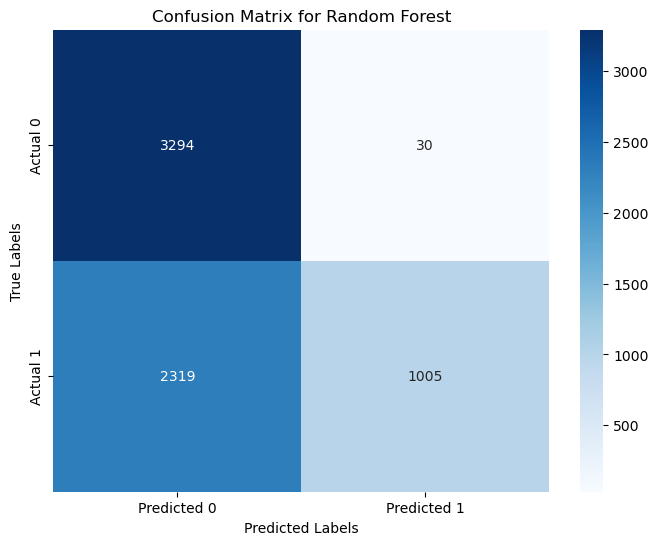

In [18]:
# Comfusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_res, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Support Vector Machine (SVM)

In [19]:
# Build the model 
from sklearn.svm import SVC

svm_model = SVC(random_state=42)

In [20]:
# Train and validate the model
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_model, X_res, y_res, cv=5)
svm_scores.mean()

0.5917232132249359

In [21]:
# Print model report
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

svm_y_pred = cross_val_predict(svm_model, X_res, y_res, cv=5)
print(classification_report(y_res, svm_y_pred))

              precision    recall  f1-score   support

           0       0.56      0.89      0.69      3324
           1       0.73      0.29      0.41      3324

    accuracy                           0.59      6648
   macro avg       0.64      0.59      0.55      6648
weighted avg       0.64      0.59      0.55      6648



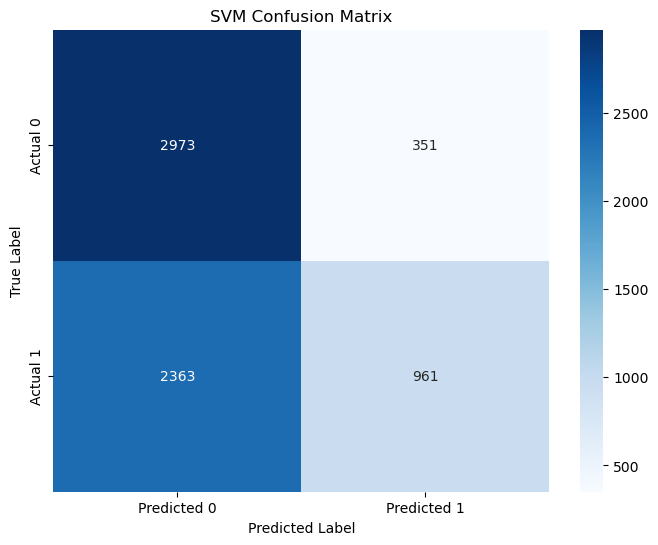

In [22]:
# Comfusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

svm_cm = confusion_matrix(y_res, svm_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(svm_cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# EXTRA

In [5]:
import numpy as np 

def window(X_data, y_data, width: int, shift: int):
    
    X_wins, y_wins = [], []

    for index, (X, y) in enumerate(zip(X_data, y_data)):
        if (index + width + shift) <= X_data.shape[0]:

            window = slice((index + width), (index + width + shift))

            X_wins.append(X_data[index: index + width])

            y_values_shift = y_data[window]
            y_wins.append(int(np.any(y_values_shift == 1)))

    X_wins = np.array(X_wins)
    y_wins = np.array(y_wins)
    return X_wins.reshape(X_wins.shape[0], -1), y_wins.flatten()

In [6]:
X_wins, y_wins = window(X, y, width=120, shift=180)

In [7]:
print(f"-> X:\t{X_wins.shape}")
print(f"-> y:\t{y_wins.shape}")

-> X:	(678746, 1560)
-> y:	(678746,)


## Undersampling

In [8]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)

X_res, y_res = rus.fit_resample(X_wins, y_wins)

In [9]:
classes, distribution = np.unique(y_res, return_counts=True)

In [10]:
print(f"-> X_res:\t{X_res.shape}")
print(f"-> y_res:\t{y_res.shape}")

-> X_res:	(6648, 1560)
-> y_res:	(6648,)


In [11]:
print(f"-> {classes[0]}:\t{distribution[0]}")
print(f"-> {classes[1]}:\t{distribution[1]}")

-> 0:	3324
-> 1:	3324


## Models

Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=1234)

SVM (Support Vector Machine).

In [13]:
from sklearn.svm import SVC

svc = SVC(random_state=1234, C=1)

LSTM (Long Short-Term Memory)

In [ ]:
X = df[features].to_numpy()
y = df[label].to_numpy().flatten()

X_wins, y_wins = window(X, y, width=120, shift=180)
X_res, y_res = rus.fit_resample(X_wins, y_wins)

train_size = int(1 - 0.3 * y_res.shape[0])
X_train, X_test = np.array(X_res[0: train_size]), np.array(X_res[train_size:])
y_train, y_test = y_res[0: train_size], y_res[train_size:]

In [ ]:
print(f"-> X_train, X_test:\t{X_train.shape}, {X_test.shape}")
print(f"-> y_train, y_test:\t{y_train.shape}, {y_test.shape}")

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))

model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=64, return_sequences=True))

model.add(Dense(units=1))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2)

In [ ]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

## K-Fold Cross Validation

In [33]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

skf = StratifiedKFold(n_splits=5)

scores = cross_val_score(rf, X_res, y_res, cv=skf)
print(f"RF:\t{scores.mean()}")

scores = cross_val_score(svc, X_res, y_res, cv=skf)
print(f"SVC:\t{scores.mean()}")

# scores = cross_val_score(lstm, X_res, y_res, cv=skf)
# print(f"LSTM:\t{scores.mean()}")

RF:	0.5670844153272572
SVC:	0.5914213298483229
